Meta-Learning for Adaptive Hedging Strategies

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)


Step 2: Data Preparation

In [2]:
# Simulate some financial data
def generate_data(num_samples=1000, num_features=10):
    X = np.random.randn(num_samples, num_features)
    y = np.random.randn(num_samples, 1)  # Simulated hedging returns
    return X, y

X, y = generate_data()
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


Step 3: Define the Model

In [3]:
class HedgingModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(HedgingModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = HedgingModel(input_size=10, hidden_size=20, output_size=1)


Step 4: Define Meta-Learning Components

In [5]:
def maml_loss(model, criterion, X, y, fast_lr):
    y_pred = model(X)
    loss = criterion(y_pred, y)
    grad = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    adapted_params = [param - fast_lr * grad_param for param, grad_param in zip(model.parameters(), grad)]
    return adapted_params

def meta_train(model, dataloader, meta_optimizer, criterion, meta_lr, fast_lr, meta_epochs, fast_epochs):
    for epoch in range(meta_epochs):
        meta_optimizer.zero_grad()
        meta_loss = 0.0

        for X_batch, y_batch in dataloader:
            adapted_params = maml_loss(model, criterion, X_batch, y_batch, fast_lr)
            for _ in range(fast_epochs):
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                meta_loss += loss

        meta_loss /= len(dataloader)
        meta_loss.backward()
        meta_optimizer.step()

        print(f'Epoch {epoch+1}/{meta_epochs}, Meta Loss: {meta_loss.item()}')

criterion = nn.MSELoss()
meta_lr = 0.001  # Set a value for the meta learning rate
meta_optimizer = optim.Adam(model.parameters(), lr=meta_lr)


Step 5: Train the Meta-Learning Model

In [6]:
meta_train(model, dataloader, meta_optimizer, criterion, meta_lr=0.001, fast_lr=0.01, meta_epochs=10, fast_epochs=5)


Epoch 1/10, Meta Loss: 4.832414627075195
Epoch 2/10, Meta Loss: 4.789037227630615
Epoch 3/10, Meta Loss: 4.878631591796875
Epoch 4/10, Meta Loss: 4.848728179931641
Epoch 5/10, Meta Loss: 4.855715751647949
Epoch 6/10, Meta Loss: 4.794649124145508
Epoch 7/10, Meta Loss: 4.766312122344971
Epoch 8/10, Meta Loss: 4.748248100280762
Epoch 9/10, Meta Loss: 4.7729644775390625
Epoch 10/10, Meta Loss: 4.856123447418213


Step 6: Evaluate the Model

Test Loss: 1.139161467552185


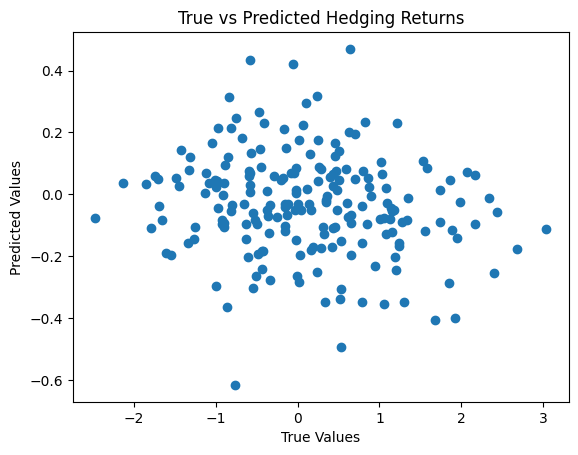

In [7]:
# Simulate new data for evaluation
X_test, y_test = generate_data(num_samples=200)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss: {test_loss.item()}')

# Plot the results
plt.scatter(y_test, y_pred.numpy())
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Hedging Returns')
plt.show()
